## Set up

Let's ensure that we have the files and packages needed. Arrange your downloaded files in the following manner.

```
src
│   doe.py
│   inverse.py

└───analyses
│   │   allowable_drift.ipynb
│   
└───data
    │   structural_db_drift_allow_loss.pickle
    │   structural_db_drift_allow_max_loss.pickle
    │   structural_db_drift_allow.pickle
    |   braceShapes.csv
    |   variable_list.csv

```

Make sure you have some installations of the following:

    - Pandas 2.2.0+
    - Numpy 1.22.4+
    - Scipy 1.12.0+
    - Scikit-learn
    - Seaborn
    - Matplotlib

Then, change the following file locations to match yours:
-   `path_to_loss_file`
-   `path_to_max_file`
-   `path_to_braceShapes`


In [2]:
# path management and package import

# this is to ensure that the .py files are recognized
import sys
sys.path.insert(1, '../')


###################### YOUR CODE HERE #############################################
# <change these to your paths> (it should be something like ../data/whatever.pickle)
path_to_loss_file = '../../data/loss/structural_db_drift_allow_loss.pickle'
path_to_max_file = '../../data/loss/structural_db_drift_allow_max_loss.pickle'

# also change this to point to the directory with the brace database
# (should be ../data/, I think)
path_to_braceShapes = '../../resource/'
###################################################################################

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP
import inverse as inv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None 

## Pre-processing

Basically, this prepares all of the variables that are used in the study and stores everything in the `df` DataFrame. You don't need to read the following stuff if it is too confusing. 

`main_obj` is the object that stores the analyses results of the 1000 points. `max_obj` is an object that stores analyses results of the same 1000 points, but assuming that everything was destroyed inside the building. This gives us a reference value so that we can calculate how much the building lost in terms of content as a percentage.

In [3]:
main_obj = pd.read_pickle(path_to_loss_file)
max_obj = pd.read_pickle(path_to_max_file)
df = inv.preprocess_data(main_obj, max_obj, db_string=path_to_braceShapes)

Here, you can take a peek at what this DataFrame contains. In the shared files, I've included a spreadsheet that explains each variable. We won't be using most of the variables.

In [4]:
# view a bit of the data
pd.set_option('display.max_columns', None)
df.head()

,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,moat_ampli,RI,L_bldg,h_bldg,zeta_e,delta_a,num_bays,num_stories,L_bay,h_story,S_s,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,mu_1,mu_2,R_1,R_2,T_e,k_e,Q,zeta_loop,D_m,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,wx,hx,h_col,hsx,Fx,Vs,T_fbe,beam,column,brace,gm_selected,scale_factor,sa_avg,sa_tm,sa_1,sa_tfb,constructed_moat,T_1,T_fb,T_ratio,gap_ratio,max_isol_disp,PID,PFV,PFA,RID,impacted,run_status,max_drift,collapse_prob,log_collapse_prob,log_drift,max_velo,max_accel,T_ratio_e,Bm,k2,k1,bldg_area,W_L,Tshift_coef,T_M_adj,replacement_cost,total_cmp_cost,cmp_replace_cost_ratio,median_cost_ratio,cmp_cost_ratio,replacement_time,total_cmp_time,cmp_replace_time_ratio,median_time_ratio,cmp_time_ratio,replacement_freq,B_50%,C_50%,D_50%,E_50%,steel_cost,steel_cost_per_sf,system
0,CBF,TFP,2.0,1.248156,3.543509,14.649668,0.559622,1.602873,84.330713,33.879726,0.139135,0.019714,3,2,28.110238,16.939863,2.2815,1955.70901,1244.542097,"[2.811023761045672, 2.811023761045672, 1.88651...","[474.11127510980117, 474.11127510980117, 318.1...","{'1.4D': [1.9677166327319702, 1.96771663273197...","{'1.4D': [331.8778925768608, 331.8778925768608...",0.040688,0.063132,15.126432,78.781224,3.543509,0.008137,0.058823,0.139137,32.859557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[711.1669126647018, 533.3751844985263]","[203.27835888609536, 406.5567177721907]","[203.27835888609536, 101.63917944304768]","[203.27835888609536, 203.27835888609536]","[53.38645763412557, 68.08531754185321]",121.471775,0.393199,"[W33X141, W30X116]","[W12X58, W12X58]","[HSS7X7X1/4, HSS6X6X3/16]",RSN4040_BAM_BAM-L,1.694723,0.840787,0.289792,1.7951,1.541415,18.388918,0.423417,0.396445,8.098314,0.680212,68.4237,"[0.4736760987624556, 1.063866321949103]","[4444.49, 7824.88, 26792.0]","[8052.096273291926, 27802.277432712217, 47517....","[0.4736760987624556, 1.063866321949103]",1,0,1.063866,1.000000e+00,-3.934852e-12,0.061910,26792.0000,47517.857143,9.011988,1.317404,0.006347,0.092977,21335.00738,853.400295,0.906033,3.210536,12801004.427965,5.639342e+06,0.440539,0.440539,1.000000,7787.277694,2889.033548,0.370994,0.370994,1.000000,1.0,4.402826e+06,777390.950352,4.021018e+05,6096.770217,97594.701159,4.574393,CBF-TFP
1,CBF,LRB,2.0,1.1376,3.052741,17.368904,0.904996,1.950874,141.727436,68.750287,0.245849,0.009152,5,5,28.345487,13.750057,2.2815,11549.833021,9541.166408,"[2.83454872055995, 2.83454872055995, 2.8345487...","[1606.93328984561, 1606.93328984561, 1606.9332...","{'1.4D': [1.984184104391965, 1.984184104391965...","{'1.4D': [1124.853302891927, 1124.853302891927...",NaN,NaN,NaN,NaN,3.052741,0.010963,0.094298,0.245852,21.354862,26.352856,6.798835,8.079017,0.336626,24.0,20.0,19.200001,3.2,"[2008.6666123070127, 2008.6666123070127, 2008....","[165.00068862241363, 330.00137724482727, 495.0...","[165.00068862241363, 165.00068862241363, 165.0...","[165.00068862241363, 165.00068862241363, 165.0...","[8.798801718075998, 43.35957038502717, 110.221...",643.841489,0.668519,"[W36X160, W36X160, W36X160, W36X135, W33X130]","[W14X145, W14X145, W14X145, W14X145, W10X26]","[HSS8X8X5/16, HSS8X8X5/16, HSS8X8X5/16, HSS8X8...",RSN577_SMART1.45_45O01EW,4.220267,0.651276,0.391553,1.130954,1.699769,19.326057,1.296037,0.793355,3.847886,0.861302,17.1235,"[0.0025096864955977526, 0.0025659892909227944,...","[35.9275, 34.9543, 33.9535, 34.0458, 34.6965, ...","[0.5083178053830227, 0.2269003623188406, 0.171...","[0.0002570352909074997, 0.0002430292887550583,...",0,0,0.002577,1.977367e-05,-1.083116e+01,-5.961145,35.9275,0.508318,4.566421,1.591699,0.006548,0.113724,120519.996738,5423.399853,1.000000,3.052741,72311998.043052,3.299165e+07,0.45624,0.012472,0.027336,43989.79881,7882.741067,0.179195,0.005621,0.031371,0.0,5.836733e+05,130851.670878,1.274696e+05,0.000000,512953.307551,4.256168,CBF-LRB
2,CBF,TFP,2.0,1.231249,3.021773,9.721468,0.853225,1.837052,227.902243,36.439439,0.125012,0.014924,8,3,28.48778,12.14648,2.2815,19477.287213,14283.343956,"[2.8487780430965977, 2

## Subset of data

The dataset contains several different steel systems. In the superstructure, there are special concentrically braced frames (CBF) and special moment resisting frames (MF). These are isolated by two types of bearings: triple friction pendulum bearings (TFP) and lead rubber bearings (LRB).

Since we might expect that the design variables affect the systems differently, we will separate the dataset into a couple of subsets to help us study them individually.

I've also found that variables might behave differently depending on whether or not they impact against the moat wall, so I've segregated those points as well, with `_i` indicating that impact occurred during the earthquake run, and `_o` indicating that impact did not occur.

In [5]:
# separate by isolators
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

# separate by superstructure
df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

# superstructures, only without impact
df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

# every permutation: MF-TFP, MF-LRB, CBF-TFP, CBF-LRB
df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']

# permutations, separated by impact condition
df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

# Study objective

In this study, we're interested in seeing how four design parameters affect three outcomes. The inputs are:

-   `gap_ratio`: How much more displacement capacity we built compared to what we expected from the earthquake. 1.0 means that we built exactly the displacement as expected from the spectrum, whereas <1.0 means that we underconstructed  the moat.
-   `RI`: Strength reduction factor. The ratio of the elastic base shear to the design base shear (also known as $R_y$ or just $R$). 1.0 means that the steel frame is designed with forces equal to the demand from the MCE ground motion. >1.0 means we've reduced the design force (inelastic design). You can find this from CE 225 notes, CE 227 notes, or my discussion from steel when we talked about inelastic earthquake design.
-   `delta_a`: Allowable drift. Maximum drift expected under the design force $\Delta_a$. Whereas $R$ controls _strength_ of the structure, $\Delta_a$ controls the _stiffness_.
-   `T_ratio`: $T_M$/$T_{fb}$. The ratio between the isolation system period and the fixed-base structure period. Basically, how much are we isolating the building. 1.0 means that the structure and the isolators are equally stiff (no isolation), and >1.0 means that some isolation effect is felt.

The outcomes are:
-   `cmp_cost_ratio`: Compared to the worst case scenario, how much do the repairs cost after an MCE
-   `cmp_time_ratio`: Compared to the worst case scenario, how long will the repairs take after an MCE
-   `replacement_freq`: What is the probability that the building will need to be demolished and rebuilt (either from collapse or too much permanent damage)?

My hypothesis is that different superstructures have different governing strength or stiffness, which varies according to their moat gap ratio. So, let's say a designer want for their building to cost no more than 10% of replacement cost. What are the design inputs needed?

## Visualize data

Now we can finally get to a bit of the data analysis. 


So. Let's see what effects the design variables have on the outcomes. Try making some plots to help you visualize the relationships between the variable. You could make your own plots, or the block below has pre-coded scatterplot-histograms, in case you need inspiration.

Some questions for you to try to answer via these plots:

1. What are the relationships between each input variable and each output variable? Which of these are significant?
2. Are these relationshps the same or different within each system? CBFs vs MFs? TFPs vs LRBs?
3. Do these relationships change if you condition on the "impact" status of the building?
4. Are there any correlations among the inputs themselves?
5. Do you think the relationships are linear? Nonlinear? Quadratic? etc.
6. Are there parts of the data that have less variance than others?

Try to explain some of these results in a physical manner as well. For example, below I show the relationship between $\Delta_a$ and repair cost, only for buildings that do not experience impact against  the moat wall. We can see that lower allowable drift lowers cost, but much more in MFs than CBFs (but why?).


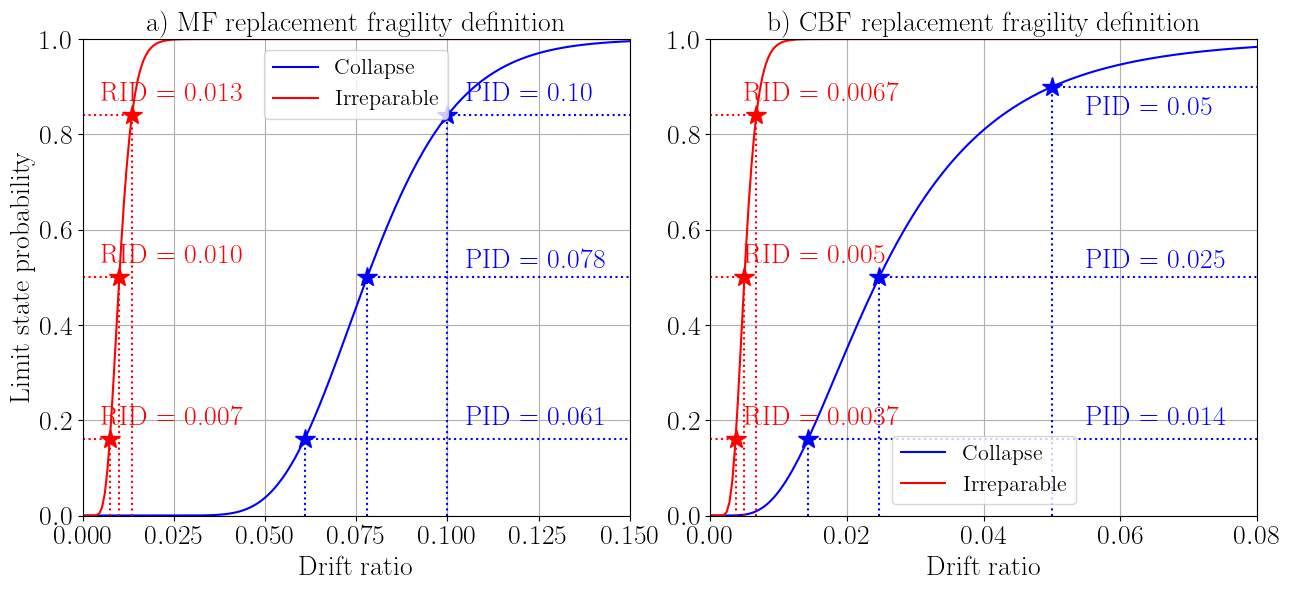

In [136]:
#%% collapse fragility def

# TODO: definitions
import numpy as np
from scipy.stats import norm
inv_norm = norm.ppf(0.84)
# collapse as a probability
from scipy.stats import lognorm
from math import log, exp

plt.rcParams["text.usetex"] = True
x = np.linspace(0, 0.15, 200)
mu = log(0.1)- 0.25*inv_norm
sigma = 0.25;

ln_dist = lognorm(s=sigma, scale=exp(mu))
p = ln_dist.cdf(np.array(x))

# plt.close('all')
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 1)
# ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(x, p, label='Collapse', color='blue')

mu_irr = log(0.01)
ln_dist_irr = lognorm(s=0.3, scale=exp(mu_irr))
p_irr = ln_dist_irr.cdf(np.array(x))

ax.plot(x, p_irr, color='red', label='Irreparable')

axis_font = 20
subt_font = 18
xleft = 0.15
ax.set_ylim([0,1])
ax.set_xlim([0, xleft])
ax.set_ylabel('Limit state probability', fontsize=axis_font)
ax.set_xlabel('Drift ratio', fontsize=axis_font)

ax.vlines(x=exp(mu), ymin=0, ymax=0.5, color='blue', linestyle=":")
ax.hlines(y=0.5, xmin=exp(mu), xmax=0.15, color='blue', linestyle=":")
ax.text(0.105, 0.52, r'PID = 0.078', fontsize=axis_font, color='blue')
ax.plot([exp(mu)], [0.5], marker='*', markersize=15, color="blue", linestyle=":")

ax.vlines(x=0.1, ymin=0, ymax=0.84, color='blue', linestyle=":")
ax.hlines(y=0.84, xmin=0.1, xmax=xleft, color='blue', linestyle=":")
ax.text(0.105, 0.87, r'PID = 0.10', fontsize=axis_font, color='blue')
ax.plot([0.10], [0.84], marker='*', markersize=15, color="blue", linestyle=":")

lower= ln_dist.ppf(0.16)
ax.vlines(x=lower, ymin=0, ymax=0.16, color='blue', linestyle=":")
ax.hlines(y=0.16, xmin=lower, xmax=xleft, color='blue', linestyle=":")
ax.text(0.105, 0.19, r'PID = 0.061', fontsize=axis_font, color='blue')
ax.plot([lower], [0.16], marker='*', markersize=15, color="blue", linestyle=":")


ax.hlines(y=0.5, xmin=0.0, xmax=exp(mu_irr), color='red', linestyle=":")
lower = ln_dist_irr.ppf(0.16)
ax.hlines(y=0.16, xmin=0.0, xmax=lower, color='red', linestyle=":")
upper = ln_dist_irr.ppf(0.84)
ax.hlines(y=0.84, xmin=0.0, xmax=upper, color='red', linestyle=":")
ax.plot([lower], [0.16], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([0.01], [0.5], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([upper], [0.84], marker='*', markersize=15, color="red", linestyle=":")
ax.vlines(x=upper, ymin=0, ymax=0.84, color='red', linestyle=":")
ax.vlines(x=0.01, ymin=0, ymax=0.5, color='red', linestyle=":")
ax.vlines(x=lower, ymin=0, ymax=0.16, color='red', linestyle=":")

ax.text(0.005, 0.19, r'RID = 0.007', fontsize=axis_font, color='red')
ax.text(0.005, 0.87, r'RID = 0.013', fontsize=axis_font, color='red')
ax.text(0.005, 0.53, r'RID = 0.010', fontsize=axis_font, color='red')

ax.set_title('a) MF replacement fragility definition', fontsize=axis_font)
ax.grid()
label_size = 16
clabel_size = 12

ax.legend(fontsize=label_size, loc='upper center')

# cbf
inv_norm = norm.ppf(0.9)
# collapse as a probability

x = np.linspace(0, 0.08, 200)
mu = log(0.05)- 0.55*inv_norm
sigma = 0.55;

ln_dist = lognorm(s=sigma, scale=exp(mu))
p = ln_dist.cdf(np.array(x))

# plt.close('all')
ax = fig.add_subplot(1, 2, 2)

ax.plot(x, p, label='Collapse', color='blue')

mu_irr = log(0.005)
ln_dist_irr = lognorm(s=0.3, scale=exp(mu_irr))
p_irr = ln_dist_irr.cdf(np.array(x))

ax.plot(x, p_irr, color='red', label='Irreparable')

axis_font = 20
subt_font = 18
xleft = 0.08
ax.set_ylim([0,1])
ax.set_xlim([0, xleft])
# ax.set_ylabel('Limit state probability', fontsize=axis_font)
ax.set_xlabel('Drift ratio', fontsize=axis_font)

ax.vlines(x=exp(mu), ymin=0, ymax=0.5, color='blue', linestyle=":")
ax.hlines(y=0.5, xmin=exp(mu), xmax=0.15, color='blue', linestyle=":")
ax.text(0.055, 0.52, r'PID = 0.025', fontsize=axis_font, color='blue')
ax.plot([exp(mu)], [0.5], marker='*', markersize=15, color="blue", linestyle=":")

ax.vlines(x=0.05, ymin=0, ymax=0.9, color='blue', linestyle=":")
ax.hlines(y=0.9, xmin=0.05, xmax=xleft, color='blue', linestyle=":")
ax.text(0.055, 0.84, r'PID = 0.05', fontsize=axis_font, color='blue')
ax.plot([0.05], [0.9], marker='*', markersize=15, color="blue", linestyle=":")

lower= ln_dist.ppf(0.16)
ax.vlines(x=lower, ymin=0, ymax=0.16, color='blue', linestyle=":")
ax.hlines(y=0.16, xmin=lower, xmax=xleft, color='blue', linestyle=":")
ax.text(0.055, 0.19, r'PID = 0.014', fontsize=axis_font, color='blue')
ax.plot([lower], [0.16], marker='*', markersize=15, color="blue", linestyle=":")


ax.hlines(y=0.5, xmin=0.0, xmax=exp(mu_irr), color='red', linestyle=":")
lower = ln_dist_irr.ppf(0.16)
ax.hlines(y=0.16, xmin=0.0, xmax=lower, color='red', linestyle=":")
upper = ln_dist_irr.ppf(0.84)
ax.hlines(y=0.84, xmin=0.0, xmax=upper, color='red', linestyle=":")
ax.plot([lower], [0.16], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([0.005], [0.5], marker='*', markersize=15, color="red", linestyle=":")
ax.plot([upper], [0.84], marker='*', markersize=15, color="red", linestyle=":")
ax.vlines(x=upper, ymin=0, ymax=0.84, color='red', linestyle=":")
ax.vlines(x=0.005, ymin=0, ymax=0.5, color='red', linestyle=":")
ax.vlines(x=lower, ymin=0, ymax=0.16, color='red', linestyle=":")

ax.text(0.005, 0.19, r'RID = 0.0037', fontsize=axis_font, color='red')
ax.text(0.005, 0.87, r'RID = 0.0067', fontsize=axis_font, color='red')
ax.text(0.005, 0.53, r'RID = 0.005', fontsize=axis_font, color='red')

ax.set_title('b) CBF replacement fragility definition', fontsize=axis_font)
ax.grid()
label_size = 16
clabel_size = 12

ax.legend(fontsize=label_size, loc='lower center')
fig.tight_layout()
plt.show()

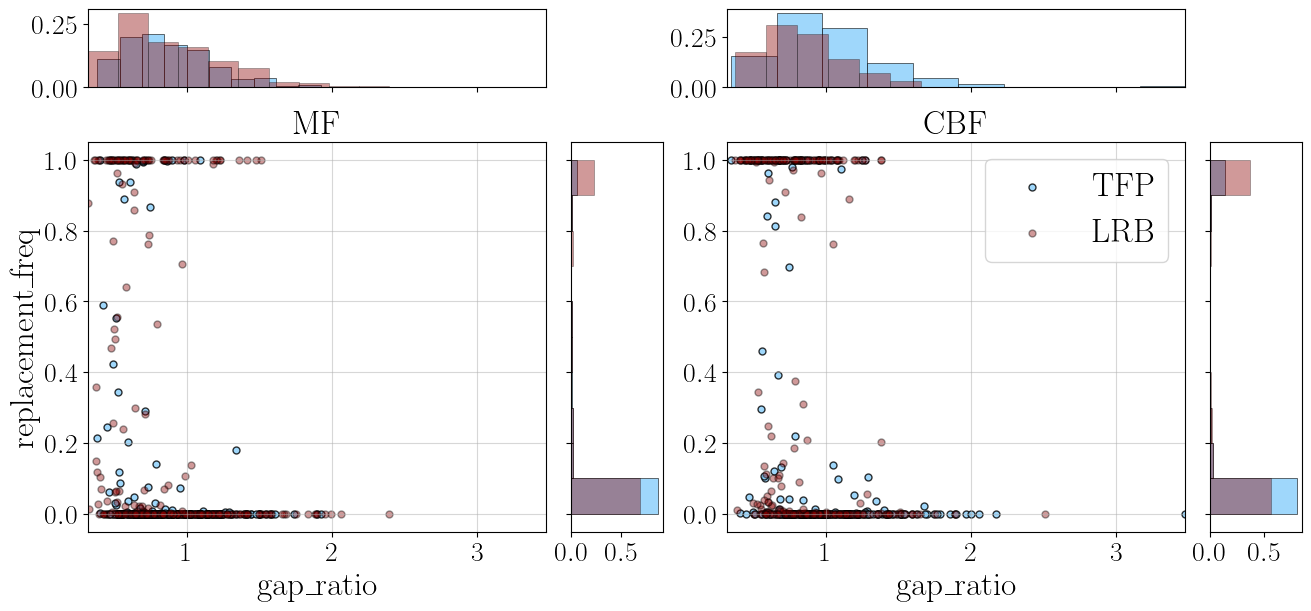

In [140]:
#%%

###################### YOUR CODE HERE #############################################
# choose your x and y variables. These are column names of df
xvar = 'gap_ratio'
yvar = 'replacement_freq'

# dataset used for each plot. you can change these to change the content of the scatter.
left_points_blue = df_mf_tfp.copy()
left_points_red = df_mf_lrb.copy()
right_points_blue = df_cbf_tfp.copy()
right_points_red = df_cbf_lrb.copy()

# you might have to change the y-limits of the plots to see meaningful trends
# ax.set_ylim([0, 0.15])
###################################################################################

def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # ax_histx.grid(True)
    # ax_histy.grid(True)
    
    # the scatter plot:
    ax.grid(True, alpha=0.5)
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
                label=label)

    n_bins = 10
    ax_histx.hist(x, bins=n_bins, alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
    
    ax_histy.hist(y, bins=n_bins, orientation='horizontal', alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
  

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 22
import matplotlib as mpl
label_size = 20
title_font = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
# Start with a square Figure.
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(left_points_blue[xvar], left_points_blue[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
             label='TFP')
scatter_hist(left_points_red[xvar], left_points_red[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
             label='LRB')
# ax.legend(fontsize=axis_font)

ax.set_title(r'MF', fontsize=title_font)

ax.set_xlabel(xvar, fontsize=axis_font)
ax.set_ylabel(yvar, fontsize=axis_font)
ax.set_xlim([df[xvar].min(), df[xvar].max()])
# ax.set_ylim([df[yvar].min(), df[yvar].max()])
# ax.set_ylim([0, 0.1])

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)

# Draw the scatter plot and marginals.

scatter_hist(right_points_blue[xvar], right_points_blue[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
              label='TFP')
scatter_hist(right_points_red[xvar], right_points_red[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
              label='LRB')

ax.set_xlim([df[xvar].min(), df[xvar].max()])
# ax.set_ylim([df[yvar].min(), df[yvar].max()])
# ax.set_ylim([0, 0.1])

ax.set_title(r'CBF', fontsize=title_font)
ax.set_xlabel(xvar, fontsize=axis_font)

ax.legend(fontsize=axis_font)

I understand that this dataset is given to you almost as a black box. Please feel free to ask me any questions at any time to explain things in more details!

Now you try it. Make any plots that you might think help you understand these relationships better (if any). Feel free to refer to `variable_list.csv` to find relationships in the data points that you might want to explore.

I sometimes find good inspiration in the Seaborn and Matplotlib galleries.

-   https://matplotlib.org/stable/gallery/index.html
-   https://seaborn.pydata.org/examples/index.html

You can access any variable with `df[your_var]`.

In [ ]:
################ YOUR PLOTS HERE ... (maybe) #################

# GP predictions

## Gaussian process models

To find out how the performance changes as design parameters varied, we ideally need experiments at every possible combination. Obviously, this is infeasible. Therefore, we rely on regression/ML models to help us interpolate the performance across the design space.


Although many different ML techniques are available, I primarily work with [Gaussian processes](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr). GPs is a regression technique that assumes that the underlying function (i.e. loss(design) ) can be represented by a Gaussian distribution of functions. GPs walk and talk a lot like linear regression, but some neat tricks allow them to serve a more non-linear and probabilistic purpose. 

Bypassing all of the math and explanations, GP outputs mainly rely on two things:
1)  A kernel, or covariance function, which describes how much each point in the dataset influence a prediction $y$ at a location, and
2)  The data points $X$, which do all the work in informing the prediction


## Preparing the data

In [121]:
# define our inputs and outputs

# output variables
cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'

# list of our 4 input study variables
covariate_list = ['gap_ratio', 'RI', 'delta_a', 'T_ratio'] 

################ YOUR CODE HERE  ##############################
# make the X and y variables

# in particular: which dataset do you want to study?
# which outcome variable do you want to observe?

raw_data = df_cbf.copy()
X_raw = raw_data[covariate_list]
y_raw = raw_data[[cost_var]]
###############################################################

print(X_raw.head())
print(y_raw.head())

# since our input variables are on different scales, we'll need to normalize them
# to a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_raw)
X_train = scaler.transform(X_raw)

# we'll also need to flatten y, as the GP functions only work with 1 dimension data
y_train = np.ravel(y_raw)

  gap_ratio        RI   delta_a   T_ratio
0  0.680212  1.602873  0.019714  8.098314
1  0.861302  1.950874  0.009152  3.847886
2  1.225517  1.837052  0.014924  5.401671
3  3.476901  1.870806  0.018114  9.896883
4  1.018156  1.405487  0.014681  5.103239
   cmp_cost_ratio
0        1.000000
1        0.027336
2        0.061662
3        0.012912
4        0.035901


## Setting up the kernel

Kernels are the heart of the GP predictions. In probabilistic term, they describe the covariance of the functions that the main GP y(x) is distributed around. In implementation terms, they somewhat resemble a distance function that describes how much any given point $x'$ is influenced by the points $X$ in the dataset. The kernel between two points is notated as $k(x,x')$. What's neat is that they extend your model from 4 features to (hypothetically) $\infty$ number of features. This is known as the _kernel trick_: by using something akin to the distance function between the query point $x'$ and the data set, we've added so many features that it converted our problem from a 4-D linear regression problem to a nonlinear regression. Since we only have 1000 data points, we have 1000 features to help us predict.

The [Scikit-learn page](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) has good documentations on all kernels available. They come in different shapes and size and have different "effects" on how your data relationship is represented.

### Squared exponential kernel

By far, the kernel I use the most is the squared exponential kernel, also known as the radial basis function (RBF):

$k(x_i, x_j) = a \exp \left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$

If you are familiar with the Gaussian (normal) distribution, this looks a lot like that. It relies on $d$, the distance between your two points. If the two points are close together, then $k$ is high. That means that a point is most influenced by the points closest to it. This value then drops off for points further out (just like a bell curve). There are two _hyperparameters_ that we don't know and will need to tune/train: a scaling coefficient $a$ and a lengthscale $l$. The scaling coefficient $a$ helps us tune the strength of the kernel, while the lengthscale helps us determine the importance of each individual input variable.

The end product is that we get prediction functions that are very smooth and can replicate general functions.

How setting up the kernel works: 

All kernel functions will differ a bit and you will need to read the documentation (Scikit-learn page above) to find out what arguments they take. In the case of the RBF, it requires one argument: either a 1.0 or a vector [1.0, 1.0, 1.0, 1.0]. This initializes the lengthscale.

-   RBF-ISO

If 1.0 is used, all the variables will share one lengthscale. That is, the model will weigh all input variables equally. For example, the effects of the gap ratio $GR$ will be considered as equally as the effects of $\Delta_a$. You might hear this flavor of the RBF kernel be described as "isotropic".

-   RBF-ARD

If the vector [1.0, 1.0, 1.0, 1.0] is used, you will allow the model to tune the importance for each variable. That means that if a variable is deemed to be unimportant, its effect can be greatly tuned down. This is sometimes called the "anisotropic" RBF kernel, or "automatic relevance determination" (ARD) flavor.

In [122]:
import sklearn.gaussian_process.kernels as krn

################ YOUR CODE HERE  #################

# decide if you want an isotropic or anisotropic kernel
RBF_lengthscale = 1.0

# use the krn.RBF() function to build the base of the kernel
kernel_base = 1.0 * krn.RBF(RBF_lengthscale)

###################################################

# to consider the fact that we are not fitting perfect data, we'll add a white 
# white noise kernel to allow for noisy predictions. We don't know how much noise
# to expect, so we'll just initialize it and allow it to be tuned, ranging from 
# 1e-8 to 100.

noise_bound = (1e-8, 1e2)
kernel_obj = kernel_base + krn.WhiteKernel(
    noise_level=0.1, noise_level_bounds=noise_bound)

## Training the data

What's neat about the GP is that the training procedure is not as intensive like a neural network. We do not need to identify a large amount of weight vectors, nor do we need to carry out backpropagation. Once we identify the hyperparameters $a$ and $l$, the predictions are _closed form_. This means that making predictions is simply carrying out a linear algebraic calculation. Here is what happens during the GP training process:

1) The model identifies which part of your kernel is tweak-able (the hyperparameters).
2) A likelihood function $\mathcal{L}$ is built for the data set $X$. That is, $\mathcal{L}(X)$ asks: under my guess of the hyperparameters, what is the probability of me observing all the points $X_1, X_2, ... X_{1000}$?
3) The function then guesses another hyperparameter and sees if $\mathcal{L}$ is higher or lower. It then repeats this until $\mathcal{L}(X)$ is as high as possible. This process is known as _optimization_. This process might need to be repeated several time in order to avoid local minimization problems.

The `GaussianProcessRegressor` function takes as argument the kernel that you've constructed, as well as how many times you'd like to repeat the optimization to avoid local minima. To remove the randomness and make sure that my result is the same as yours, I also set the random state seed to my favorite number.

In [123]:

from sklearn.gaussian_process import GaussianProcessRegressor

################ YOUR CODE HERE  #################
# set up the GP regressor
seed = 985
n_repeat = 10
gp_mdl = GaussianProcessRegressor(
    kernel=kernel_obj, random_state=seed, n_restarts_optimizer=n_repeat)
###################################################

# fit the GP to our processed data
import time
t0 = time.time()
gp_mdl.fit(X, y)
tp = time.time() - t0

print("GP training done in %.3f s!" % tp)

GP training done in 0.560 s!


## Testing

Once we've trained a GP, we can now put it to use by testing the predictions for any hypothetical point. Let's say I'm interested in a building that has a $GR=0.9$, $R_y = 2.0$, $\Delta_a = 0.015$, and $T_M/T_{fb} = 3.2$.

In [129]:
X_test = pd.DataFrame(
    np.array([[0.9, 2.0, 0.015, 3.2]]), columns=covariate_list)

# remember to put your test point through the normalizing scaler
X_test_scaled = scaler.transform(X_test)

# GP prediction
cost_prediction = gp_mdl.predict(X_test_scaled)

print("The test building has a loss ratio of %.3f" % cost_prediction)

The test building has a loss ratio of 0.135


### Making prediction plot for design space

You might have already guessed it: we now want these predictions for all possible design points! I also want to make a plot of these. Although there is a small problem: there are 4 dimensions and my eyes can only see 2 dimensions on a screen. So any time we make a prediction for two variables $x_1$ and $x_2$, we'll have to fix the third and fourth variable. I wrote a function to do this below.

In [130]:
def make_2D_plotting_space(X, res, x_var='gap_ratio', y_var='RI', 
                           all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                           third_var_set = None, fourth_var_set = None,
                           x_bounds=None, y_bounds=None):
    
    if x_bounds == None:
        x_min = min(X[x_var])
        x_max = max(X[x_var])
    else:
        x_min = x_bounds[0]
        x_max = x_bounds[1]
    if y_bounds == None:
        y_min = min(X[y_var])
        y_max = max(X[y_var])
    else:
        y_min = y_bounds[0]
        y_max = y_bounds[1]
    xx, yy = np.meshgrid(np.linspace(x_min,
                                     x_max,
                                     res),
                         np.linspace(y_min,
                                     y_max,
                                     res))

    rem_vars = [i for i in all_vars if i not in [x_var, y_var]]
    third_var = rem_vars[0]
    fourth_var = rem_vars[-1]
       
    xx = xx
    yy = yy
    
    if third_var_set is None:
        third_var_val= X[third_var].median()
    else:
        third_var_val = third_var_set
    if fourth_var_set is None:
        fourth_var_val = X[fourth_var].median()
    else:
        fourth_var_val = fourth_var_set
    
    
    X_pl = pd.DataFrame({x_var:xx.ravel(),
                         y_var:yy.ravel(),
                         third_var:np.repeat(third_var_val,
                                             res*res),
                         fourth_var:np.repeat(fourth_var_val, 
                                              res*res)})
    X_plot = X_pl[all_vars]
                         
    return(X_plot)

Let's put it to use. Below, I make a plotting space for $R_y$ and $\Delta_a$. I want 75 points in each dimension, and I want to see the effects at a code-compliant moat gap ($GR = 1.0$). I don't care about $T_M/T_{fb}$, so I'll let the function set it to the data median.

In [134]:
# define the resolution (how many points per dimension)
res = 75

################ YOUR CODE HERE  #################
# variables plotted
xvar = 'RI'
yvar = 'delta_a'

# where to fix the third and fourth variable
# if not set, will be set to median of the dataset
fixed_GR = 1.0

##################################################

X_plot = make_2D_plotting_space(
    X_raw, res, x_var=xvar, y_var=yvar, 
    all_vars=covariate_list, third_var_set = fixed_GR)

Make the contour plot:

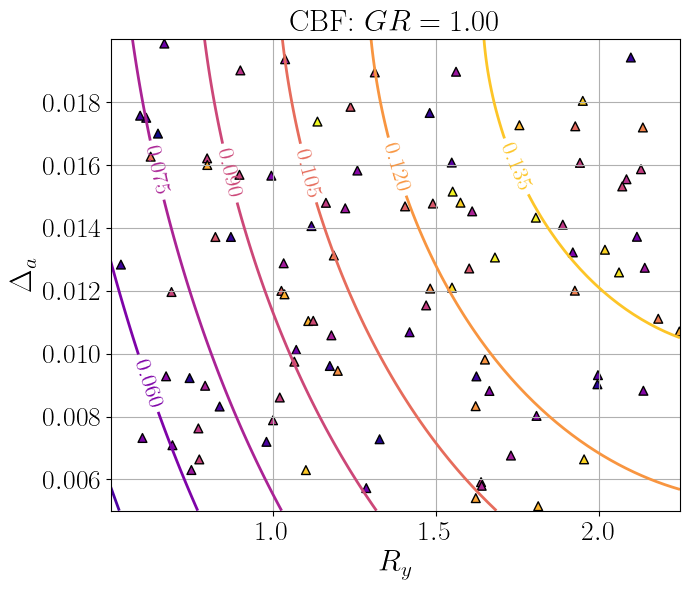

In [135]:

# plot settings
title_map ={'gap_ratio': '$GR$',
            'RI': '$R_y$',
            'delta_a': '$\Delta_a$',
            'T_ratio': '$T_M/T_{fb}$'}

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig = plt.figure(figsize=(7, 6))

# grab the x and y axes values, make a grid
xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

# make the prediction

ax = fig.add_subplot(1, 1, 1)
X_plot_scaled = scaler.transform(X_plot)
grid_cost = gp_mdl.predict(X_plot_scaled)

# use the predictions to make contour plots
Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)
cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0,
                cmap='plasma')

# make scatter plots with the data points closest to the slice
X_near = raw_data[(raw_data['gap_ratio'] > fixed_GR-0.1) &
                  (raw_data['gap_ratio'] < fixed_GR+0.1)]
ax.scatter(X_near[xvar], X_near[yvar], c=X_near['gap_ratio'],
            s=40, marker='^', edgecolors='black', cmap='plasma')

clabels = ax.clabel(cs, fontsize=clabel_size)
ax.grid(visible=True)

# titles, labels

try:
    current_system = raw_data['system'].unique().item()
    fix_string = str(current_system) + ": $GR = %.2f$" % fixed_GR
except:
    current_system = raw_data['superstructure_system'].unique().item()
    fix_string = str(current_system) + ": $GR = %.2f$" % fixed_GR
    
ax.set_title(fix_string, fontsize=title_font)

ax.set_xlabel(title_map[xvar], fontsize=axis_font)
ax.set_ylabel(title_map[yvar], fontsize=axis_font)

fig.tight_layout()
plt.show()

Make any other plots that you think might help you answer research questions. You may try to plot the above in 3D, or perhaps create a GIF that cycles through different $GR$, or slice it further to present the answer in 1D.

In [133]:
################ YOUR PLOTS HERE ... (maybe) #################

## GP exploration

Here are some questions for you to answer by changing the GP parameters.

1.  What happens if you train the model but do not allow for noise in the kernel?
2.  How does your model change if you switch the kernel from RBF-ISO to RBF-ARD? (you might have to change the fixed $GR$ value to answer this)
3.  Try changing to a totally different kernel. Refer to the documentation link from Scikit-learn. Some to consider:
    -   Matern kernels are like RBFs, but a little more jagged
    -   Rational quadratics behave a lot like RBFs
    -   Exp-sine-squared is best for periodic data (sinusoidal)

ML models are nice, but it's very important to keep some engineering judgment at hand. From your expectation of the data, what kernel/settings do you think best represent the relationship between design variables and the loss outcomes? Why do you think so?

## Engineering questions

Let's revisit our study objective and use the GP model above to answer some questions.

For MF-TFPs:
1.  What is the relationship between the studied variables ($R_y$ and $\Delta_a$) and repair cost ratio?
2.  How do these trends change if you change $GR$? If you change $T_M/T_{fb}$?
3.  At $GR = 1.0$, what design variables would you recommend if a designer wants to limit their loss to $\leq 0.10$?
4.  For this system, does it seem that strength ($R_y$) or stiffness ($\Delta_a$) is more important? Why?

Repeat your study for repair downtime. Then repeat your study for the four different systems. Answer the questions above.